## Importations

In [1]:
## plots
import matplotlib.pyplot as plt
from matplotlib import rc

##
import seaborn as sns

import sys
sys.path.append('../')

## ML :
from scripts.machine_learning_utils import *
from scripts.models import *
from scripts.descriptors import *

rc('font', family='sans-serif', size = 7)
rc('figure', dpi= 700)
rc(('xtick', 'ytick'), labelsize = 7)
rc('legend', fontsize=6)
rc('lines', linewidth = 1)
rc('axes', linewidth = 0.5, labelsize =8)
rc('legend', handlelength = 2)

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import r_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import make_pipeline



Skipped loading some PyTorch models, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'torch'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


## Get data

In [2]:
df_total = pd.read_csv('../tables/data/df_total.csv').set_index('SMILES')

In [11]:
df_ONO = df_total[df_total.group == 'ONO']
X_ONO = create_descriptors(df_ONO.index, "quantum")
names = get_names('quantum')
df_X_ONO = pd.DataFrame(X_ONO, index = df_ONO.index, columns = names)
df_X_ONO['FIA'] = df_ONO['FIA']

In [15]:
df_X_ONO.to_csv('../tables/data/df_ONO_quantum_FIA.csv')
df_X_ONO.to_excel('../tables/data/df_ONO_quantum_FIA.xlsx')

In [3]:
df_ONO_train = pd.read_csv("../tables/data/ONO_train_set.csv").set_index('SMILES')
df_ONO_test = pd.read_csv("../tables/data/ONO_test_set.csv").set_index('SMILES')

### Create concatenated descriptors

In [4]:
df = df_ONO_train
X_rdkit = create_descriptors(df.index, "rdkit")
X_hammett = create_descriptors(df.index, "hammett", structure = 'ONO')
X_rdkit_hammett = np.concatenate((X_rdkit, X_hammett), axis = 1)


In [5]:
X_rdkit_train = create_descriptors(df_ONO_train.index, "rdkit")
X_hammett_train = create_descriptors(df_ONO_train.index, "hammett", structure = 'ONO')
X_rdkit_hammett_ONO_train = np.concatenate((X_rdkit_train, X_hammett_train), axis = 1)

X_rdkit_test = create_descriptors(df_ONO_test.index, "rdkit")
X_hammett_test = create_descriptors(df_ONO_test.index, "hammett", structure = 'ONO')
X_rdkit_hammett_ONO_test = np.concatenate((X_rdkit_test, X_hammett_test), axis = 1)

Y_train = df_ONO_train.FIA
Y_test = df_ONO_test.FIA

## Feature selection

In [6]:
select_feat = SelectKBest(f_regression, k = 126 )
select_feat.fit(X_rdkit_hammett_ONO_train, Y_train)

SelectKBest(k=126, score_func=<function f_regression at 0x000001920F26C160>)

In [7]:
names_rdkit_hammett = get_names('rdkit') + get_names('hammett')

In [8]:
selected_features = select_feat.get_feature_names_out(names_rdkit_hammett)
selected_features

array(['MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex', 'qed',
       'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons',
       'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge',
       'MinAbsPartialCharge', 'FpDensityMorgan3', 'BCUT2D_MWHI',
       'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW',
       'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'BalabanJ', 'BertzCT', 'Chi0',
       'Chi1', 'Chi2n', 'Chi3v', 'Chi4v', 'HallKierAlpha', 'Ipc',
       'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1',
       'PEOE_VSA10', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14',
       'PEOE_VSA2', 'PEOE_VSA4', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9',
       'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA5', 'SMR_VSA6',
       'SMR_VSA7', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11',
       'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA4', 'SlogP_VSA6',
       'SlogP_VSA7', 'TPSA', 'EState_VSA1', 'EState_VSA10', 'EState_VSA2',
       'EState_VSA4', 'EState_VSA7', 'EState_V

### Useful functions

In [13]:
def train_predict_oracle(X_train, X_validation, Y_train, Y_validation, model):
    var_selector =  VarianceThreshold()
    X_train = var_selector.fit_transform(X_train)
    X_validation = var_selector.transform(X_validation)
    scaler = StandardScaler().fit(X_train) ## descriptors are scaled
    X_train = scaler.transform(X_train)
    X_validation = scaler.transform(X_validation)    
    # it is very important to fit the preprocessing only 
    #on train data to avoid data leakage
    select_feat = SelectKBest(f_regression, k = 126 )
    X_train = select_feat.fit_transform(X_train, Y_train)
    X_validation = select_feat.transform(X_validation)
    
    model.fit(X_train, Y_train)
    Y_pred_test = model.predict(X_validation)
    MAE = mean_absolute_error(Y_validation, model.predict(X_validation))
    return(Y_pred_test,MAE)

def K_Fold_model_evaluation_oracle(model,X,Y,n_fold, n_repet):
    
    total_Y_validation = []
    total_Y_pred_validation = []
    list_MAE = []
    
    for i in range(n_repet):
        KF = KFold(n_splits=n_fold, shuffle=True)# do not fix the random state or it will give the same split for each n_rep
        for i, (train_index, validation_index) in enumerate(KF.split(X,Y)):
            X_train = X[train_index]
            X_validation = X[validation_index]
            Y_train = Y[train_index]
            Y_validation = Y[validation_index]

            Y_pred_test,MAE = train_predict(X_train, X_validation, Y_train, Y_validation, model)

            for elt in Y_validation :
                total_Y_validation.append(elt)
            for elt in Y_pred_test :
                total_Y_pred_validation.append(elt)
            
            list_MAE.append(MAE)    
    
    return(total_Y_validation, total_Y_pred_validation, list_MAE)

### Evaluate best model

In [15]:
model = Ridge(alpha=0.7, solver='sparse_cg', tol=1e-06)

In [16]:
total_Y_validation, total_Y_pred_validation, list_MAE = K_Fold_model_evaluation_oracle(model,X_rdkit_hammett_ONO_train,Y_train,
                                                                    n_fold =10, n_repet = 10)
print('MAE on train set :', np.mean(list_MAE))

MAE on train set : 6.934534849695013


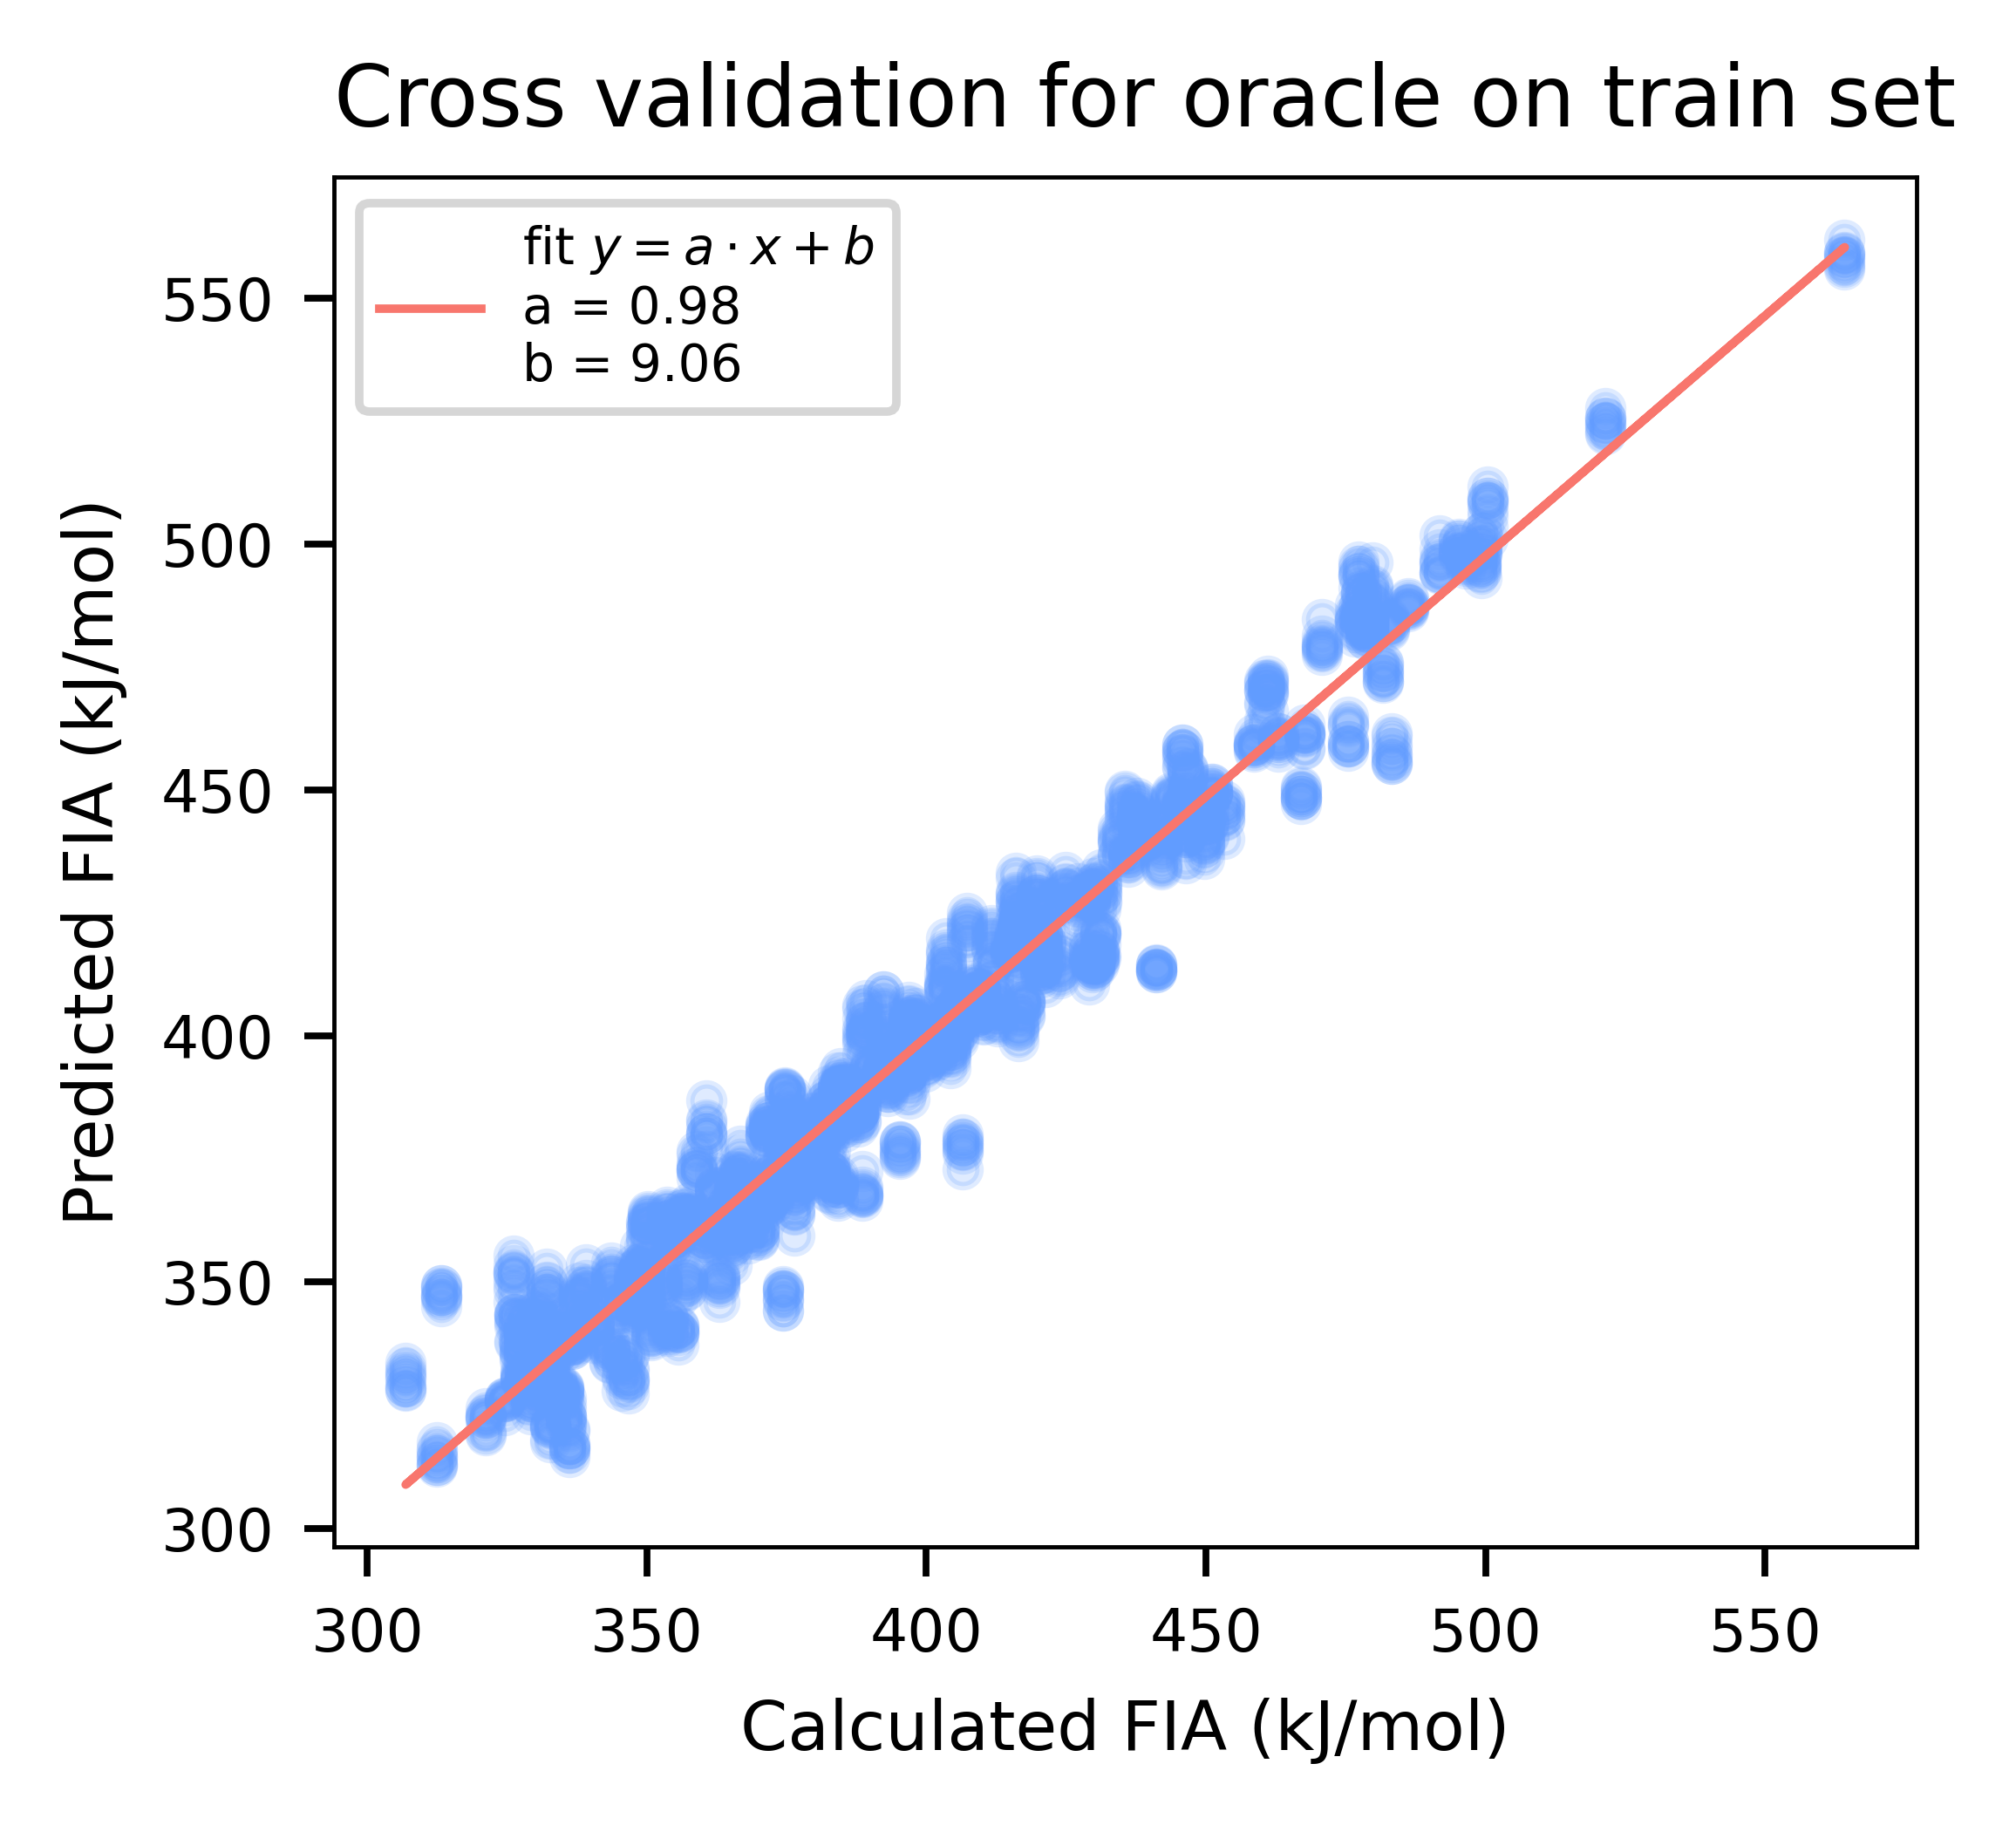

In [19]:

fig, ax = plt.subplots(figsize=(3.25, 3))

plt.ylabel('Predicted FIA (kJ/mol)')
plt.xlabel('Calculated FIA (kJ/mol)')


plt.scatter(x=total_Y_validation, y=total_Y_pred_validation, s = 15, c="#619CFF", alpha=0.2)


z = np.polyfit(total_Y_validation, total_Y_pred_validation, 1)
p = np.poly1d(z)
    
plt.plot(total_Y_validation,p(total_Y_validation),"#F8766D", label = f"fit $y=a \cdot x+b$ \na = {round(z[0],2)} \nb = {round(z[1],2)}")

ax.set_title('Cross validation for oracle on train set', loc='left', fontsize =10)
plt.tight_layout()
plt.legend()
plt.show()

## Performances on test set

In [22]:
scaler = StandardScaler().fit(X_rdkit_hammett_ONO_train) ## descriptors are scaled
X_train = scaler.transform(X_rdkit_hammett_ONO_train)
X_test = scaler.transform(X_rdkit_hammett_ONO_test)    
    # it is very important to fit the preprocessing only 
    #on train data to avoid data leakage
var_selector =  VarianceThreshold()
X_train = var_selector.fit_transform(X_train)
X_test = var_selector.transform(X_test)
    
f_selector = SelectKBest(f_regression, k = 126)
f_selector.fit(X_train, Y_train)
X_train = f_selector.transform(X_train) 
X_test = f_selector.transform(X_test)
    
model.fit(X_train, Y_train)
Y_pred_test = model.predict(X_test)
MAE = mean_absolute_error(Y_test, Y_pred_test)
R2= r2_score(Y_test, Y_pred_test)

print('MAE on test set :', MAE)
print('R2 on test set :', R2)

MAE on test set : 5.391334579491825
R2 on test set : 0.9781640773767364


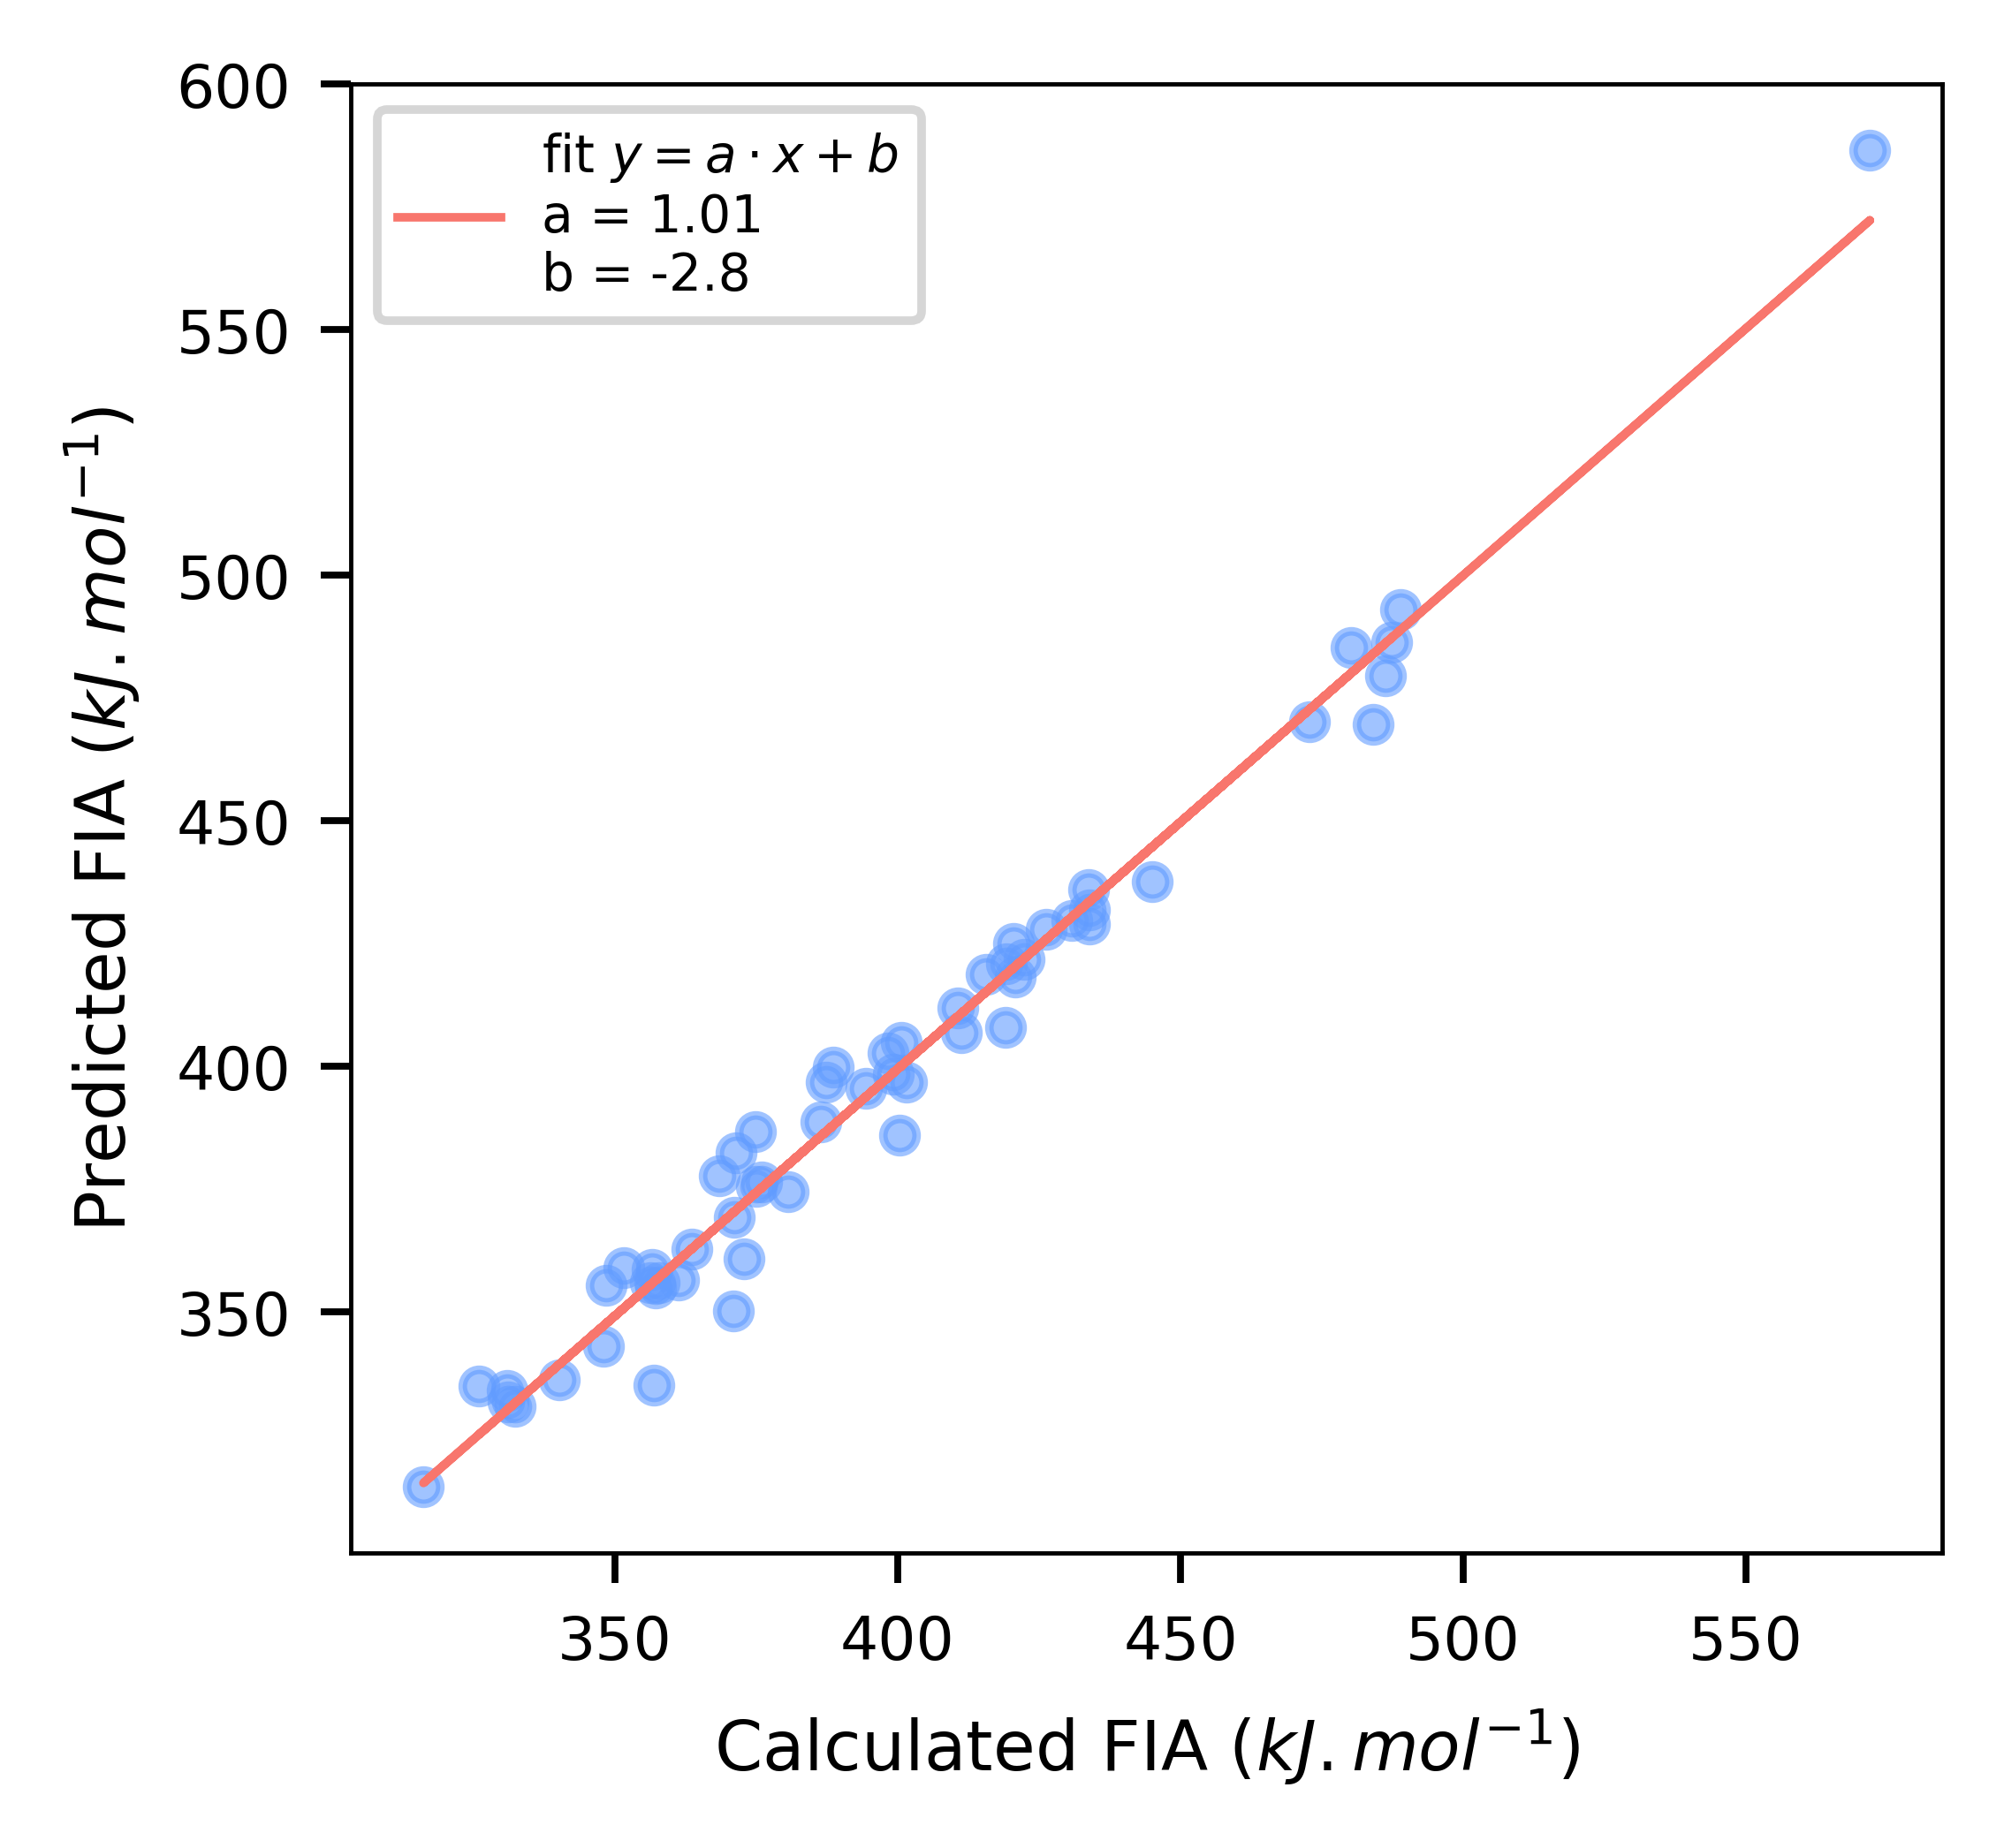

In [25]:
fig, ax = plt.subplots(figsize=(3.25, 3))

plt.ylabel('Predicted FIA ($kJ.mol^{-1}$)')
plt.xlabel('Calculated FIA ($kJ.mol^{-1}$)')


plt.scatter(x=Y_test, y=Y_pred_test, s = 15, c="#619CFF", alpha=0.6)


z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
    
plt.plot(Y_test,p(Y_test),"#F8766D", label = f"fit $y=a \cdot x+b$ \na = {round(z[0],2)} \nb = {round(z[1],2)}")

#ax.set_title('B.', loc='left', fontsize =10)
plt.tight_layout()
plt.legend()
plt.show()

fig.savefig(f'../results/oracle/CV_plot_oracle_model_ONO_test_set.png', facecolor = 'white', format = 'png', transparent = True, bbox_inches='tight')

In [ ]:
pipe=make_pipeline(VarianceThreshold(),StandardScaler(), SelectKBest(f_regression, k = 126), model)

pipe.fit(X_rdkit_hammett_ONO_train,Y_train)
Y_pred_test = pipe.predict(X_rdkit_hammett_ONO_test)
MAE = mean_absolute_error(Y_test, Y_pred_test)
print('MAE on test set :', MAE)

MAE on test set : 5.391519690078086


## Predict all ONO chemical space

Generate SMILES for all possible compounds

In [31]:
all_possible_smiles = []
smi_base = 'c1(*)c(*)c(OB4N2(c3c(O4)c(*)c(*)c(*)c3))c2cc1(*)'
frags = ['N', 'O', 'Cl', 'F', 'Br', 'C', 'OC', 'N(C)C',
          '[H]',"C#N", "C(C)(C)C", "C(F)(F)F","[N+]([O-])=O"]
for frag in frags :
    L = list(smi_base)
    L[3]=L[30]= frag
    for frag2 in frags :
        L[26] = L[7] = frag2
        for frag3 in frags :
            L[46] = L[34] = frag3
            new_L = "".join(L)
            mol  = Chem.MolFromSmiles(new_L)
            smi = Chem.MolToSmiles(mol)
            all_possible_smiles.append(smi) 

In [32]:
df_all_smiles = pd.DataFrame()
df_all_smiles['SMILES']= all_possible_smiles
df_all_smiles = df_all_smiles.set_index('SMILES')
df_all_smiles.to_csv('../tables/data/all_possible_smiles_ONO.csv')

In [33]:
df_all_smiles = pd.read_csv('../tables/data/all_possible_smiles_ONO.csv').set_index('SMILES')

Featurize molecules

In [35]:
df_ONO = df_total[df_total.group =='ONO']
df = df_ONO
X_rdkit = create_descriptors(df.index, "rdkit")
X_hammett = create_descriptors(df.index, "hammett", structure = 'ONO')
X_rdkit_hammett_ONO = np.concatenate((X_rdkit, X_hammett), axis = 1)

Y_ONO = df.FIA

In [36]:
df = df_all_smiles
X_rdkit = create_descriptors(df.index, "rdkit")
X_hammett = create_descriptors(df.index, "hammett", structure = 'ONO')
X_rdkit_hammett_all_smiles = np.concatenate((X_rdkit, X_hammett), axis = 1)

#### Fit the model on existing data and predict for all smiles

In [38]:
pipe.fit(X_rdkit_hammett_ONO, Y_ONO)

Pipeline(steps=[('variancethreshold', VarianceThreshold()),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=126,
                             score_func=<function f_regression at 0x0000022B0385C160>)),
                ('ridge', Ridge(alpha=0.7, solver='sparse_cg', tol=1e-06))])

In [ ]:
FIA_pred_all_smiles = pipe.predict(X_rdkit_hammett_all_smiles)

#### Save data

In [ ]:
df_all_smiles["FIA"]= FIA_pred_all_smiles


df_all_smiles.to_csv('../tables/data/all_possible_smiles_FIA_ONO.csv')

